In [1]:
import tensorflow as tf
import numpy as np

from sklearn.metrics import accuracy_score

### MNIST Dataset

In [2]:
# load mnist data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# reshape and normalize data
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

# convert labels to integer
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

# split dataset into train and validation set
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [3]:
class DNN:
    def __init__(self):
        # input and output shapes
#         self.n_inputs = 28*28 # shape of MNIST images
        self.n_hidden1 = 300 # 1st layer
        self.n_hidden2 = 100 # 2nd layer
        self.n_outputs = 10 # output layer, 10 digits

        # hyperparameters
        self.n_epochs = 40
        self.batch_size = 50
        self.learning_rate = 0.01

        self.model_name = "dnn-mnist"
    
    def dense_layer(self, X, size, name, activation=None):
        """method that encapsulates a single layer of a feedforward neural network"""
        with tf.name_scope(name):
            input_size = int(X.get_shape()[1])
            # sample according to xavier weight initialization technique
            xavier_initialization = tf.truncated_normal((input_size, size), stddev=2/np.sqrt(input_size))
            W = tf.Variable(xavier_initialization, dtype=tf.float32, name="weight")
            b = tf.Variable(np.zeros([size]), dtype=tf.float32, name="bias")
            z = tf.matmul(X, W) + b
        if activation == "relu":
            return tf.nn.relu(z)
        else:
            return z
    
    def mlp(self, X):
        with tf.name_scope("dnn"):
            hidden1 = self.dense_layer(X, self.n_hidden1, "hidden1", activation="relu")
            hidden2 = self.dense_layer(hidden1, self.n_hidden2, "hidden2", activation="relu")
            outputs = self.dense_layer(hidden2, self.n_outputs, "outputs")
            logits = tf.nn.sigmoid(outputs, name="logits")
        
        return outputs, logits
    
    def shuffle_batch(self, X, y):
        rnd_idx = np.random.permutation(len(X))
        n_batches = len(X) // self.batch_size
        for batch_idx in np.array_split(rnd_idx, n_batches):
            X_batch, y_batch = X[batch_idx], y[batch_idx]
            yield X_batch, y_batch
    
    def _infer(self, X):
        output, logits = self.mlp(X)
        
        with tf.name_scope("prediction"):
            y_pred = tf.math.argmax(logits, axis=1)
        return output, logits, y_pred
    
    def _loss_fn(self, logits, labels):
        with tf.name_scope("loss"):
            cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
            loss = tf.reduce_mean(cross_entropy, name="loss")
        return loss
    
    def _optimize_fn(self, loss):
        with tf.name_scope("optimizer"):
            optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
            optimize_op = optimizer.minimize(loss)
        return optimize_op
    
    def _eval_fn(self, logits, y):
        with tf.name_scope("evaluate"):
            # tp: images that we predicted correctly
            tp = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(tp, tf.float32))
            accuracy_summary = tf.summary.scalar('accuracy', accuracy)
        return accuracy
    
    def _train(self, X, y):
        output, predicted_proba, predicted_label = self._infer(X)
        loss = self._loss_fn(output, y)
        optimize_op = self._optimize_fn(loss)
        
        loss_summary = tf.summary.scalar('log_loss', loss)
        
        return optimize_op, loss, predicted_proba
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        tf.reset_default_graph()
        input_dim = X_train.shape[1]
        output_dim = y_train.shape[0]
        
        X = tf.placeholder(dtype=tf.float32, shape=(None, input_dim), name="X")
        y = tf.placeholder(dtype=tf.int32, shape=(None,), name="y")
        
        optimize_op, loss, predicted_proba = self._train(X, y)
        accuracy = self._eval_fn(predicted_proba, y)
        
        summary_op = tf.summary.merge_all()
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            train_writer = tf.summary.FileWriter("tf_logs/{model}/train_summary".format(model=self.model_name), sess.graph)
            valid_writer = tf.summary.FileWriter("tf_logs/{model}/valid_summary".format(model=self.model_name), sess.graph)
            for epoch in range(self.n_epochs):
                for i, (X_batch, y_batch) in enumerate(self.shuffle_batch(X_train, y_train)):
                    _, train_summary = sess.run([optimize_op, summary_op], feed_dict={X: X_batch, y: y_batch})

                train_writer.add_summary(train_summary, epoch)
                accuracy_val, loss_val, valid_summary = sess.run([accuracy, loss, summary_op], feed_dict={X: X_valid, y: y_valid})
                valid_writer.add_summary(valid_summary, epoch)

                print(epoch, "Validation accuracy:", accuracy_val, ", Validaton Loss:", loss_val)

            save_path = saver.save(sess, "tf_logs/{model}/model.ckpt".format(model=self.model_name))
    
    def predict(self, X_test):

        input_dim = X_test.shape[1]
        
        tf.reset_default_graph()
        X = tf.placeholder(shape=[None, input_dim], dtype=tf.float32, name="input")
        
        _, logits, preds = self._infer(X)
        
        self.saver = tf.train.Saver()

        with tf.Session() as sess:
            self.saver.restore(sess, "tf_logs/{model}/model.ckpt".format(model=self.model_name))

            # Result on test set batch.
            logits_test, preds_test = sess.run([logits, preds], {X: X_test})

        return preds_test, logits_test


In [30]:
DNN().fit(X_train, y_train, X_valid, y_valid)

(?, 10)
(?, 10)
0 Validation accuracy: 0.9162 , Validaton Loss: 0.30630141
1 Validation accuracy: 0.9352 , Validaton Loss: 0.23913532
2 Validation accuracy: 0.9454 , Validaton Loss: 0.20411281
3 Validation accuracy: 0.9502 , Validaton Loss: 0.181509
4 Validation accuracy: 0.9546 , Validaton Loss: 0.16670328
5 Validation accuracy: 0.9602 , Validaton Loss: 0.15294836
6 Validation accuracy: 0.962 , Validaton Loss: 0.1424138
7 Validation accuracy: 0.963 , Validaton Loss: 0.13676895
8 Validation accuracy: 0.9654 , Validaton Loss: 0.12677358
9 Validation accuracy: 0.967 , Validaton Loss: 0.12136215
10 Validation accuracy: 0.969 , Validaton Loss: 0.11583159
11 Validation accuracy: 0.969 , Validaton Loss: 0.11216262
12 Validation accuracy: 0.9702 , Validaton Loss: 0.1057509
13 Validation accuracy: 0.971 , Validaton Loss: 0.104279906
14 Validation accuracy: 0.9706 , Validaton Loss: 0.099683866
15 Validation accuracy: 0.9716 , Validaton Loss: 0.09761627
16 Validation accuracy: 0.9714 , Validaton

In [4]:
import matplotlib.pyplot as plt

INFO:tensorflow:Restoring parameters from tf_logs/dnn-mnist/model.ckpt


(array([1]),
 array([[0.00223768, 0.99999905, 0.77370834, 0.87840426, 0.34380037,
         0.02013161, 0.03771162, 0.94163543, 0.9884288 , 0.12480121]],
       dtype=float32))

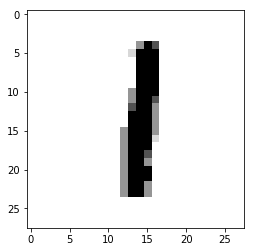

In [5]:
c = np.random.randint(X_test.shape[0])
image = X_test[c]
plt.imshow(image.reshape((28,28)), cmap='Greys')
DNN().predict(image.reshape(1,784))

## Adversarial Attack

In [139]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, (None, 28*28))
X_hat = tf.Variable(np.zeros([1, 28*28]), dtype=tf.float32, name="X_hat")
assign_op = tf.assign(X_hat, X)
y_hat = tf.placeholder(tf.int32, (None,))

learning_rate = 0.01
# labels = tf.reshape(tf.one_hot(y_hat, 10), (10,))
output, logits, _ = DNN()._infer(X_hat)
loss = DNN()._loss_fn(output, y_hat)

# loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=output)
optimize_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[X_hat])

In [140]:
tf.trainable_variables()

[<tf.Variable 'X_hat:0' shape=(1, 784) dtype=float32_ref>,
 <tf.Variable 'dnn/hidden1/weight:0' shape=(784, 300) dtype=float32_ref>,
 <tf.Variable 'dnn/hidden1/bias:0' shape=(300,) dtype=float32_ref>,
 <tf.Variable 'dnn/hidden2/weight:0' shape=(300, 100) dtype=float32_ref>,
 <tf.Variable 'dnn/hidden2/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dnn/outputs/weight:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'dnn/outputs/bias:0' shape=(10,) dtype=float32_ref>]

In [141]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(assign_op, feed_dict={X: training_example})

    for i in range(1000):
        _, loss_value = sess.run([optimize_op, loss], feed_dict={y_hat: [4]})
        if i % 100 == 0:
            print('loss={}'.format(loss_value))
    adv = X_hat.eval()

loss=1.5959819555282593
loss=0.28551343083381653
loss=0.1584867238998413
loss=0.10962539166212082
loss=0.08399546146392822
loss=0.06811459362506866
loss=0.05723772570490837
loss=0.04944736883044243
loss=0.043569568544626236
loss=0.03903026878833771


In [142]:
DNN().predict(X_test[0].reshape(1, 784))

INFO:tensorflow:Restoring parameters from tf_logs/dnn-mnist/model.ckpt


(array([7]),
 array([[3.4682870e-01, 5.4198904e-03, 9.5374697e-01, 9.9063206e-01,
         1.4025898e-03, 2.4133573e-01, 3.4396802e-05, 9.9999499e-01,
         2.1551281e-01, 8.5841882e-01]], dtype=float32))

In [143]:
DNN().predict(adv.reshape(1,784))

INFO:tensorflow:Restoring parameters from tf_logs/dnn-mnist/model.ckpt


(array([7]),
 array([[5.97642422e-01, 8.44278838e-03, 9.84283805e-01, 9.97051120e-01,
         4.26000275e-04, 2.09219292e-01, 1.20509385e-05, 9.99996662e-01,
         1.28022730e-01, 8.27773571e-01]], dtype=float32))